In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

In [3]:
from pyspark.sql import SparkSession

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("Heart Attack Analysis").getOrCreate()

# Đọc dữ liệu
df = spark.read.option("inferSchema", True).option("header", True).csv("D:/data/heart_attack_china.csv")

# Tạo TempView
df.createOrReplaceTempView("heart_attack")

# Hiển thị 5 dòng đầu tiên
df.show(5)

+----------+---+------+--------------+------------+--------+-------+-----------------+----------------------+-----------------+----------+------------+-------------------+------------------+-----------------+--------------+-------+---------+---------------------+-------+-----------------+---------------+------------+--------------+----------------------+---------------------+--------------+------------+
|Patient_ID|Age|Gender|Smoking_Status|Hypertension|Diabetes|Obesity|Cholesterol_Level|Air_Pollution_Exposure|Physical_Activity|Diet_Score|Stress_Level|Alcohol_Consumption|Family_History_CVD|Healthcare_Access|Rural_or_Urban| Region| Province|Hospital_Availability|TCM_Use|Employment_Status|Education_Level|Income_Level|Blood_Pressure|Chronic_Kidney_Disease|Previous_Heart_Attack|CVD_Risk_Score|Heart_Attack|
+----------+---+------+--------------+------------+--------+-------+-----------------+----------------------+-----------------+----------+------------+-------------------+---------------

In [9]:
# Lọc các cột dạng số (int, double, float, long)
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double', 'float', 'bigint']]

# Bỏ 1 cột đầu
numeric_cols_trimmed = numeric_cols[1:]

# Describe
df.select(numeric_cols_trimmed).describe().show()

+-------+-----------------+------------------+------------------+
|summary|              Age|    Blood_Pressure|    CVD_Risk_Score|
+-------+-----------------+------------------+------------------+
|  count|           239266|            239266|            239266|
|   mean|59.46628438641512|141.23294575911328|  54.4855809015907|
| stddev|17.34830790255569| 20.31509242180432|25.987742815519855|
|    min|               30|                90|                10|
|    max|               89|               179|                99|
+-------+-----------------+------------------+------------------+



In [32]:
df.printSchema()

root
 |-- Patient_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Smoking_Status: string (nullable = true)
 |-- Hypertension: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Obesity: string (nullable = true)
 |-- Cholesterol_Level: string (nullable = true)
 |-- Air_Pollution_Exposure: string (nullable = true)
 |-- Physical_Activity: string (nullable = true)
 |-- Diet_Score: string (nullable = true)
 |-- Stress_Level: string (nullable = true)
 |-- Alcohol_Consumption: string (nullable = true)
 |-- Family_History_CVD: string (nullable = true)
 |-- Healthcare_Access: string (nullable = true)
 |-- Rural_or_Urban: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Hospital_Availability: string (nullable = true)
 |-- TCM_Use: string (nullable = true)
 |-- Employment_Status: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Inco

In [5]:
df.describe().show()

+-------+-----------------+-----------------+------+--------------+------------+--------+-------+-----------------+----------------------+-----------------+----------+------------+-------------------+------------------+-----------------+--------------+-------+--------+---------------------+-------+-----------------+---------------+------------+------------------+----------------------+---------------------+------------------+------------+
|summary|       Patient_ID|              Age|Gender|Smoking_Status|Hypertension|Diabetes|Obesity|Cholesterol_Level|Air_Pollution_Exposure|Physical_Activity|Diet_Score|Stress_Level|Alcohol_Consumption|Family_History_CVD|Healthcare_Access|Rural_or_Urban| Region|Province|Hospital_Availability|TCM_Use|Employment_Status|Education_Level|Income_Level|    Blood_Pressure|Chronic_Kidney_Disease|Previous_Heart_Attack|    CVD_Risk_Score|Heart_Attack|
+-------+-----------------+-----------------+------+--------------+------------+--------+-------+-----------------

In [6]:
from pyspark.sql.functions import col, sum

# 1. Hiển thị 10 dòng đầu tiên của DataFrame
df.show(10)

# 2. Thống kê mô tả cho tất cả các cột số
numeric_cols = [c for c, t in df.dtypes if t in ['int', 'double', 'float', 'bigint']]
if numeric_cols:
    df.select(numeric_cols).describe().show()
else:
    print("Không có cột số nào để thống kê mô tả.")

# 3. Thống kê số lượng giá trị NULL cho mỗi cột
null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in df.columns
])
null_counts.show()

# Kiểm tra xem có cột nào có NULL không và bao nhiêu NULL
null_summary = null_counts.collect()[0].asDict()
for col_name, null_count in null_summary.items():
    if null_count > 0:
        print(f"Cột {col_name.replace('_nulls','')} có {null_count} giá trị NULL")

# 4. Thống kê số dòng trùng lặp
total_rows = df.count()
distinct_rows = df.dropDuplicates().count()
duplicate_rows = total_rows - distinct_rows

print(f"Tổng số dòng      : {total_rows}")
print(f"Số dòng duy nhất  : {distinct_rows}")
print(f"Số dòng bị trùng  : {duplicate_rows}")


+----------+---+------+--------------+------------+--------+-------+-----------------+----------------------+-----------------+----------+------------+-------------------+------------------+-----------------+--------------+--------+---------+---------------------+-------+-----------------+---------------+------------+--------------+----------------------+---------------------+--------------+------------+
|Patient_ID|Age|Gender|Smoking_Status|Hypertension|Diabetes|Obesity|Cholesterol_Level|Air_Pollution_Exposure|Physical_Activity|Diet_Score|Stress_Level|Alcohol_Consumption|Family_History_CVD|Healthcare_Access|Rural_or_Urban|  Region| Province|Hospital_Availability|TCM_Use|Employment_Status|Education_Level|Income_Level|Blood_Pressure|Chronic_Kidney_Disease|Previous_Heart_Attack|CVD_Risk_Score|Heart_Attack|
+----------+---+------+--------------+------------+--------+-------+-----------------+----------------------+-----------------+----------+------------+-------------------+-------------

In [10]:
#Câu 1:
print("Câu 1: Số lượng người mắc bệnh tim  theo nhóm tuổi, khu vực sống và giới tính")
df1 = spark.sql("""
   SELECT
       CASE
           WHEN Age BETWEEN 30 AND 50 THEN 'Middle-aged'
           ELSE 'Older_Adult'
       END AS Age_Group, Rural_or_Urban, Gender,
       COUNT(Gender) AS Heart_Attack_Cases
   FROM heart_attack
   WHERE Heart_Attack = 'Yes'
   GROUP BY Gender, Age_Group, Rural_or_Urban
   ORDER BY Heart_Attack_Cases DESC
""").toPandas()
df1


Câu 1: Số lượng người mắc bệnh tim  theo nhóm tuổi, khu vực sống và giới tính


,Age_Group,Rural_or_Urban,Gender,Heart_Attack_Cases
0,Older_Adult,Rural,Female,27027
1,Older_Adult,Rural,Male,26717
2,Older_Adult,Urban,Male,17834
3,Older_Adult,Urban,Female,17756
4,Middle-aged,Rural,Female,14661
5,Middle-aged,Rural,Male,14495
6,Middle-aged,Urban,Female,9818
7,Middle-aged,Urban,Male,9772


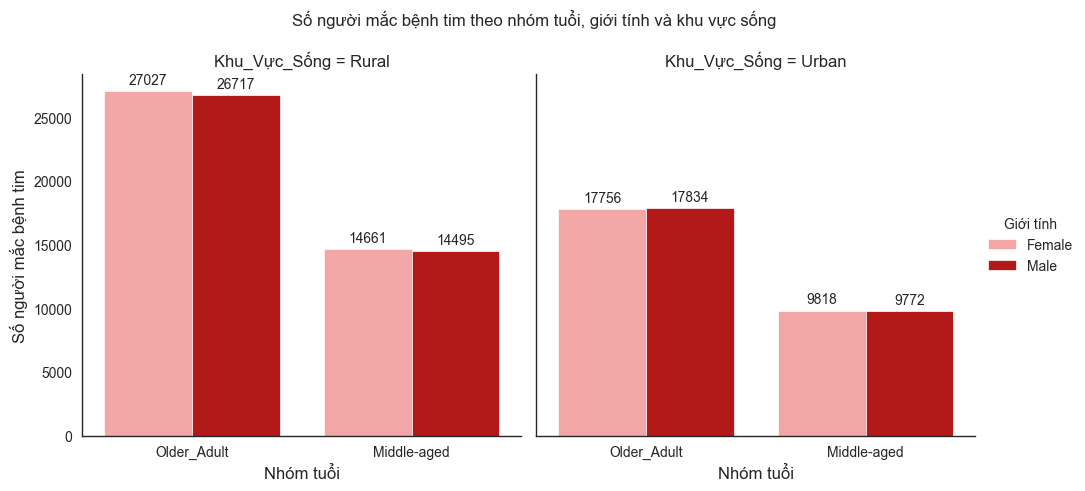

In [11]:
# Đổi tên cột sang tiếng Việt
df1_vn = df1.rename(columns={
    "Age_Group": "Nhóm_Tuổi",
    "Heart_Attack_Cases": "Số_Ca_Tim",
    "Gender": "Giới_Tính",
    "Rural_or_Urban": "Khu_Vực_Sống"
})

# Sắp xếp các nhóm tuổi để tô màu từ đậm đến nhạt theo từng nhóm
age_order = df1_vn["Nhóm_Tuổi"].unique()
num_groups = len(age_order)
reds_palette = sns.color_palette("Reds", num_groups)
age_color_map = dict(zip(sorted(age_order), reds_palette))

# Ánh xạ màu đỏ nhạt dần theo Nhóm Tuổi
sns.set_style("white")
g = sns.catplot(
    data=df1_vn,
    kind="bar",
    x="Nhóm_Tuổi",
    y="Số_Ca_Tim",
    hue="Giới_Tính",
    col="Khu_Vực_Sống",
    errorbar=None,
    height=5,
    aspect=1,
    palette=["#ff9999", "#cc0000"]
)

# Tiêu đề chính
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Số người mắc bệnh tim theo nhóm tuổi, giới tính và khu vực sống")

# Gắn nhãn trục
g.set_axis_labels("Nhóm tuổi", "Số người mắc bệnh tim")
g._legend.set_title("Giới tính")

# Thêm nhãn dữ liệu trên mỗi cột
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", padding=3)

plt.show()

In [12]:
~~~~~~~~~~~~~~~~#Câu 2:
print("Câu 2: Số lượng bệnh nhân mắc bệnh tim theo mức độ stress, thu nhập: ")
df2=spark.sql("""
    SELECT
        Stress_Level, Income_Level,
        SUM(CASE WHEN Heart_Attack = 'Yes' THEN 1 ELSE 0 END) AS Heart_Attack_Cases
    FROM heart_attack
    GROUP BY Income_Level,Stress_Level
    ORDER BY Heart_Attack_Cases DESC
""").toPandas()
df2

Câu 2: Số lượng bệnh nhân mắc bệnh tim theo mức độ stress, thu nhập: 


,Stress_Level,Income_Level,Heart_Attack_Cases
0,High,Low,16444
1,High,High,16347
2,High,Middle,16272
3,Medium,High,14945
4,Low,Low,14923
5,Low,High,14911
6,Low,Middle,14848
7,Medium,Middle,14786
8,Medium,Low,14604


C:\Users\Acer\AppData\Local\Temp\ipykernel_1820\2983052765.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


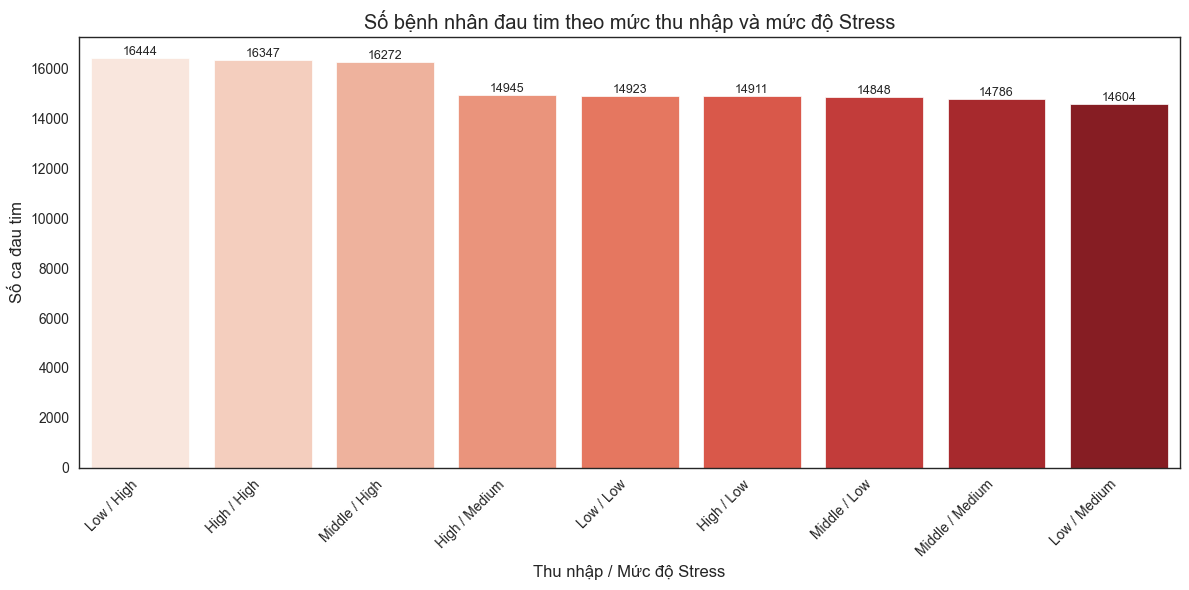

In [13]:
# Tạo cột group kết hợp giữa Thu nhập và Mức độ Stress
df2["group"] = df2["Income_Level"] + " / " + df2["Stress_Level"]

# Sắp xếp nhóm theo số ca để ánh xạ màu ổn định
df2_sorted = df2.sort_values("Heart_Attack_Cases", ascending=False)
unique_groups = df2_sorted["group"].unique()

# Tạo bảng màu xanh nhạt dần (Blues)
colors = sns.color_palette("Reds", n_colors=len(unique_groups))

# Ánh xạ group -> màu
group_to_color = {group: colors[i] for i, group in enumerate(unique_groups)}

# Đặt white background
sns.set_style("white")

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="group",
    y="Heart_Attack_Cases",
    data=df2_sorted,
    palette=[group_to_color[g] for g in df2_sorted["group"]],
)

# Xoay nhãn trục x
plt.xticks(rotation=45, ha="right")
plt.title("Số bệnh nhân đau tim theo mức thu nhập và mức độ Stress")
plt.xlabel("Thu nhập / Mức độ Stress")
plt.ylabel("Số ca đau tim")

# Thêm nhãn dữ liệu trên cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
# Lấy tổng số người bị bệnh tim
total_heart_attack = spark.sql("""
    SELECT COUNT(*) AS total
    FROM heart_attack
    WHERE Heart_Attack = 'Yes'
""").collect()[0]["total"]

In [39]:
# Câu 3: Trung bình số % bệnh nhân bị mắc bệnh tim theo nhóm hành vi sức khỏe và lối sống
print("Câu 3: Tỷ lệ % bệnh nhân bị mắc bệnh tim theo nhóm hành vi sức khỏe và lối sống")
df3=spark.sql(f"""
    SELECT
        Smoking_Status,
        Alcohol_Consumption,
        Physical_Activity,
        Diet_Score,
        Stress_Level,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_heart_attack}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes'
    GROUP BY Smoking_Status, Alcohol_Consumption, Physical_Activity, Diet_Score, Stress_Level
    ORDER BY Heart_Attack_Percentage DESC
""").toPandas()
df3

Câu 3: Tỷ lệ % bệnh nhân bị mắc bệnh tim theo nhóm hành vi sức khỏe và lối sống


,Smoking_Status,Alcohol_Consumption,Physical_Activity,Diet_Score,Stress_Level,Heart_Attack_Cases,Heart_Attack_Percentage
0,Smoker,Yes,Medium,Moderate,High,2764,2.00
1,Smoker,Yes,Low,Moderate,High,2710,1.96
2,Smoker,Yes,High,Moderate,High,2700,1.96
3,Smoker,Yes,Medium,Poor,High,2686,1.95
4,Smoker,Yes,Low,Healthy,High,2683,1.94
...,...,...,...,...,...,...,...
103,Non-Smoker,No,Medium,Poor,Medium,251,0.18
104,Non-Smoker,No,Low,Poor,Low,254,0.18
105,Non-Smoker,No,Medium,Moderate,Low,250,0.18
106,Non-Smoker,No,Low,Healthy,High,228,0.17


In [9]:
~~~~~~~~~~~~#Câu 4: Mối quan hệ giữa Blood_Pressure và Heart_Attack theo Cholesterol_Level bằng phân lớp
print("Câu 4a: Mối quan hệ giữa Blood_Pressure và Cholesterol_Level theo tỷ lệ mắc bệnh tim theo Top 3 cao nhất")

# Truy vấn Top 3 cao nhất
df_4a = spark.sql(f"""
   SELECT
       CASE
           WHEN Blood_Pressure < 120 THEN 'Normal'
           WHEN Blood_Pressure BETWEEN 120 AND 129 THEN 'Elevated'
           WHEN Blood_Pressure BETWEEN 130 AND 139 THEN 'Stage 1 Hypertension'
           WHEN Blood_Pressure >= 140 THEN 'Stage 2 Hypertension'
       END AS BP_Category,
       Cholesterol_Level,
       ROUND(100.0 * COUNT(*) / {total_heart_attack}, 2) AS Heart_Attack_Percentage
   FROM heart_attack
   WHERE Heart_Attack = 'Yes'
   GROUP BY BP_Category, Cholesterol_Level
   ORDER BY Heart_Attack_Percentage DESC
   LIMIT 3
""").toPandas()
df_4a

Câu 4a: Mối quan hệ giữa Blood_Pressure và Cholesterol_Level theo tỷ lệ mắc bệnh tim theo Top 3 cao nhất


,BP_Category,Cholesterol_Level,Heart_Attack_Percentage
0,Stage 2 Hypertension,High,15.14
1,Stage 2 Hypertension,Normal,15.09
2,Stage 2 Hypertension,Low,14.97


In [10]:
# Truy vấn Top 3 thấp nhất
print("Câu 4b: Mối quan hệ giữa Blood_Pressure và Cholesterol_Level theo tỷ lệ mắc bệnh tim theo Top 3 thấp nhất")
df_4b = spark.sql(f"""
   SELECT
       CASE
           WHEN Blood_Pressure < 120 THEN 'Normal'
           WHEN Blood_Pressure BETWEEN 120 AND 129 THEN 'Elevated'
           WHEN Blood_Pressure BETWEEN 130 AND 139 THEN 'Stage 1 Hypertension'
           WHEN Blood_Pressure >= 140 THEN 'Stage 2 Hypertension'
       END AS BP_Category,
       Cholesterol_Level,
       ROUND(100.0 * COUNT(*) / {total_heart_attack}, 2) AS Heart_Attack_Percentage
   FROM heart_attack
   WHERE Heart_Attack = 'Yes'
   GROUP BY BP_Category, Cholesterol_Level
   ORDER BY Heart_Attack_Percentage ASC
   LIMIT 3
""").toPandas()
df_4b

Câu 4b: Mối quan hệ giữa Blood_Pressure và Cholesterol_Level theo tỷ lệ mắc bệnh tim theo Top 3 thấp nhất


,BP_Category,Cholesterol_Level,Heart_Attack_Percentage
0,Normal,Low,3.66
1,Normal,High,3.69
2,Normal,Normal,3.71


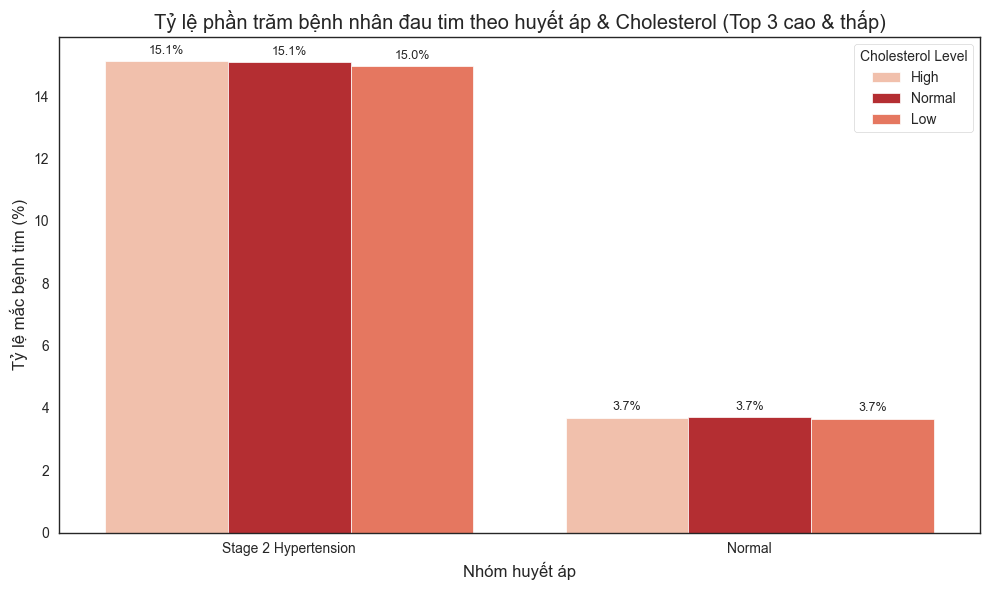

In [42]:
# Gộp 2 bảng
df_4a["Group"] = "Top 3 cao nhất"
df_4b["Group"] = "Top 3 thấp nhất"
combined_df = pd.concat([df_4a, df_4b])

# Vẽ biểu đồ cột nhóm
unique_chol = sorted(combined_df["Cholesterol_Level"].unique())
reds_palette = sns.color_palette("Reds", len(unique_chol))
chol_color_map = dict(zip(unique_chol, reds_palette))

# Vẽ biểu đồ cột nhóm
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=combined_df,
    x="BP_Category",
    y="Heart_Attack_Percentage",
    hue="Cholesterol_Level",
    palette=chol_color_map  # Sử dụng màu đỏ từ nhạt đến đậm
)

# Thêm data label
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3, fontsize=9)

# Tùy chỉnh biểu đồ
plt.title("Tỷ lệ phần trăm bệnh nhân đau tim theo huyết áp & Cholesterol (Top 3 cao & thấp)")
plt.ylabel("Tỷ lệ mắc bệnh tim (%)")
plt.xlabel("Nhóm huyết áp")
plt.legend(title="Cholesterol Level")
plt.tight_layout()
plt.show()

In [43]:
# Tính TOTAL người bị nhồi máu tim lần đầu
total_first_heart_attack = spark.sql("""
    SELECT COUNT(*) as cnt
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No'
""").collect()[0]['cnt']

# Phân tích tổ hợp 4 bệnh lý — chỉ người bị nhồi máu cơ tim lần đầu
print("Câu 5a: Tỷ lệ mắc bệnh tim ở nhóm yếu tố bệnh lý & lâm sàng với những người chưa bị bệnh tim trước đó")

df_5a=spark.sql(f"""
    SELECT
        Hypertension,
        Diabetes,
        Obesity,
        Chronic_Kidney_Disease,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_first_heart_attack}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No'
    GROUP BY Hypertension, Diabetes, Obesity, Chronic_Kidney_Disease
    ORDER BY Heart_Attack_Percentage DESC
""").toPandas()
df_5a

Câu 5a: Tỷ lệ mắc bệnh tim ở nhóm yếu tố bệnh lý & lâm sàng với những người chưa bị bệnh tim trước đó


,Hypertension,Diabetes,Obesity,Chronic_Kidney_Disease,Heart_Attack_Cases,Heart_Attack_Percentage
0,Yes,Yes,Yes,Yes,47873,38.64
1,Yes,Yes,No,Yes,20520,16.56
2,No,Yes,Yes,Yes,17649,14.24
3,Yes,Yes,Yes,No,8252,6.66
4,No,Yes,No,Yes,7747,6.25
5,Yes,No,Yes,Yes,5927,4.78
6,Yes,Yes,No,No,3631,2.93
7,No,Yes,Yes,No,3193,2.58
8,Yes,No,No,Yes,2514,2.03
9,No,No,Yes,Yes,2237,1.81


C:\Users\Acer\AppData\Local\Temp\ipykernel_25656\3819071247.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


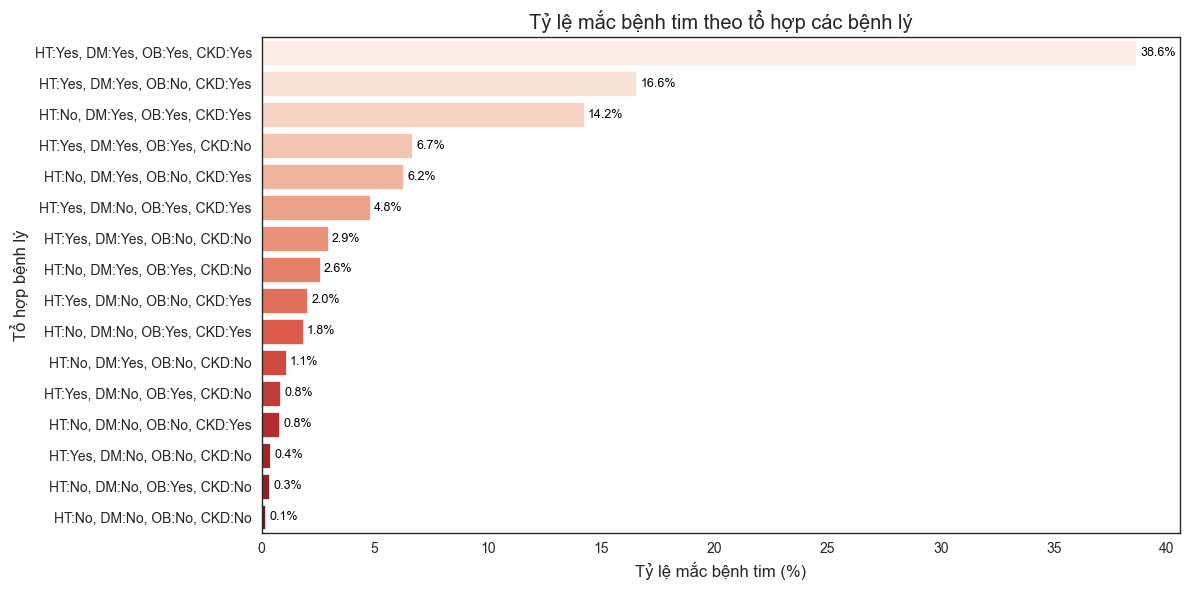

In [44]:
# Tạo cột mô tả tổ hợp bệnh lý
df_5a['Condition_Combo'] = (
    'HT:' + df_5a['Hypertension'] + ', ' +
    'DM:' + df_5a['Diabetes'] + ', ' +
    'OB:' + df_5a['Obesity'] + ', ' +
    'CKD:' + df_5a['Chronic_Kidney_Disease']
)

# Tạo bảng màu đỏ nhạt đến đậm
reds = sns.color_palette("Reds", df_5a['Condition_Combo'].nunique())

# Tạo figure và axes đúng cách
fig, ax = plt.subplots(figsize=(12, 6))

# Vẽ biểu đồ cột ngang
sns.barplot(
    data=df_5a,
    y="Condition_Combo",
    x="Heart_Attack_Percentage",
    palette=reds,
    ax=ax
)

# Gắn nhãn trục và tiêu đề
ax.set_xlabel("Tỷ lệ mắc bệnh tim (%)")
ax.set_ylabel("Tổ hợp bệnh lý")
ax.set_title("Tỷ lệ mắc bệnh tim theo tổ hợp các bệnh lý")

# Thêm data labels trên từng cột
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=9, color='black', xytext=(3, 0),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [45]:
# Tổng số người bị nhồi máu cơ tim lần đầu và có ít nhất một bệnh lý
total_with_condition = spark.sql("""
    SELECT COUNT(*) as cnt
    FROM heart_attack
    WHERE Heart_Attack = 'Yes'
      AND Previous_Heart_Attack = 'No'
      AND (
          Hypertension = 'Yes' OR
          Diabetes = 'Yes' OR
          Obesity = 'Yes' OR
          Chronic_Kidney_Disease = 'Yes'
      )
""").collect()[0]['cnt']
print("Câu 5b: Tỷ lệ mắc bệnh tim ở nhóm có ít nhất một yếu tố bệnh lý")
spark.sql(f"""
    SELECT
        'Hypertension' AS Disease,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_with_condition}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No' AND Hypertension = 'Yes'

    UNION ALL

    SELECT
        'Diabetes' AS Disease,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_with_condition}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No' AND Diabetes = 'Yes'

    UNION ALL

    SELECT
        'Obesity' AS Disease,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_with_condition}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No' AND Obesity = 'Yes'

    UNION ALL

    SELECT
        'Chronic_Kidney_Disease' AS Disease,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_with_condition}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes' AND Previous_Heart_Attack = 'No' AND Chronic_Kidney_Disease = 'Yes'

    ORDER BY Heart_Attack_Percentage DESC
""").show()


Câu 5b: Tỷ lệ mắc bệnh tim ở nhóm có ít nhất một yếu tố bệnh lý
+--------------------+------------------+-----------------------+
|             Disease|Heart_Attack_Cases|Heart_Attack_Percentage|
+--------------------+------------------+-----------------------+
|            Diabetes|            110201|                  89.08|
|Chronic_Kidney_Di...|            105417|                  85.22|
|        Hypertension|             90183|                  72.90|
|             Obesity|             86546|                  69.96|
+--------------------+------------------+-----------------------+



In [46]:
#Câu 6: Phân tích nguy cơ mắc bệnh tim do di truyền từ cha mẹ
print("Câu 6: Phân tích nguy cơ mắc bệnh tim theo yếu tố di truyền từ cha mẹ")
df_6=spark.sql("""
    SELECT
        Family_History_CVD,
        Risk_Level,
        COUNT(*) AS Patient_Count
    FROM (
        SELECT
            Family_History_CVD,
            CASE
                WHEN CVD_Risk_Score BETWEEN 10 AND 19 THEN 'Low Risk'
                WHEN CVD_Risk_Score BETWEEN 20 AND 39 THEN 'Moderate Risk'
                WHEN CVD_Risk_Score BETWEEN 40 AND 59 THEN 'High Risk'
                WHEN CVD_Risk_Score BETWEEN 60 AND 79 THEN 'Very High Risk'
                ELSE 'Extremely High Risk'
            END AS Risk_Level
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' OR Previous_Heart_Attack = 'Yes'
    ) sub
    GROUP BY Family_History_CVD, Risk_Level
    ORDER BY Patient_Count DESC
""").toPandas()
df_6

Câu 6: Phân tích nguy cơ mắc bệnh tim theo yếu tố di truyền từ cha mẹ


,Family_History_CVD,Risk_Level,Patient_Count
0,No,Moderate Risk,24888
1,No,Very High Risk,24598
2,No,High Risk,24593
3,No,Extremely High Risk,24519
4,No,Low Risk,12253
5,Yes,Very High Risk,8274
6,Yes,Moderate Risk,8231
7,Yes,Extremely High Risk,8218
8,Yes,High Risk,8105
9,Yes,Low Risk,4178


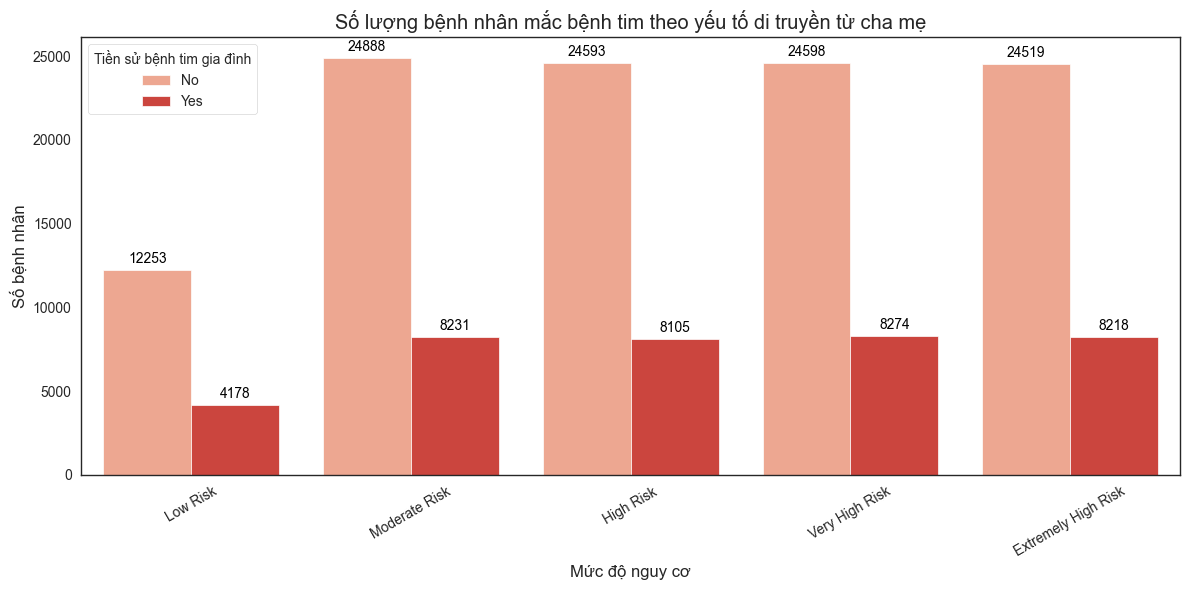

In [47]:
# Đặt thứ tự cho Risk_Level để biểu đồ đẹp hơn
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk', 'Extremely High Risk']

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_6,
    x='Risk_Level',
    y='Patient_Count',
    hue='Family_History_CVD',
    order=risk_order,
    palette='Reds'
)

# Thêm nhãn giá trị trên từng cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

plt.title('Số lượng bệnh nhân mắc bệnh tim theo yếu tố di truyền từ cha mẹ')
plt.xlabel('Mức độ nguy cơ')
plt.ylabel('Số bệnh nhân')
plt.legend(title='Tiền sử bệnh tim gia đình')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [48]:
#Câu 7: Top 10 khu vực và chất lượng không khí có nhiều bệnh nhân bị bệnh tim nhất
print("Câu 7: Tỷ lệ người mắc bệnh tim theo yếu tố chất lượng không khí")

df_7=spark.sql("""
    WITH heart_attack_filtered AS (
        SELECT *
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' AND Air_Pollution_Exposure IN ('Low', 'Medium', 'High')
    ),
    total_cases AS (
        SELECT COUNT(*) AS total FROM heart_attack_filtered
    )
    SELECT
        Air_Pollution_Exposure,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS Heart_Attack_Percentage
    FROM heart_attack_filtered
    GROUP BY Air_Pollution_Exposure
    ORDER BY Heart_Attack_Percentage DESC
""").toPandas()
df_7

Câu 7: Tỷ lệ người mắc bệnh tim theo yếu tố chất lượng không khí


,Air_Pollution_Exposure,Heart_Attack_Percentage
0,High,50.10
1,Medium,29.91
2,Low,19.99


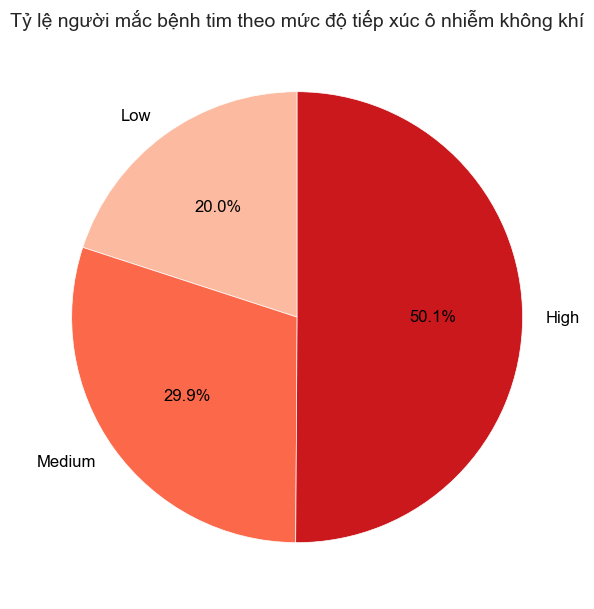

In [49]:
# Sắp xếp theo thứ tự
order = ['Low', 'Medium', 'High']
df_7_sorted = df_7.set_index('Air_Pollution_Exposure').loc[order].reset_index()

# Tạo bảng màu Reds tương ứng
reds = sns.color_palette("Reds", n_colors=len(order)).as_hex()

plt.figure(figsize=(6, 8))
wedges, texts, autotexts = plt.pie(
    df_7_sorted['Heart_Attack_Percentage'],
    labels=df_7_sorted['Air_Pollution_Exposure'],
    autopct='%1.1f%%',
    colors=reds,
    startangle=90,
    textprops={'color': 'black', 'fontsize': 12}
)

plt.title("Tỷ lệ người mắc bệnh tim theo mức độ tiếp xúc ô nhiễm không khí", fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
#Câu 8:
print("Câu 8: Phân tích tỷ lệ mắc bệnh tim theo nhóm tiếp cận y tế & chăm sóc sức khỏe")
df_8=spark.sql(f"""
    SELECT
        Healthcare_Access,
        Hospital_Availability,
        COUNT(*) AS Heart_Attack_Cases,
        ROUND(100.0 * COUNT(*) / {total_heart_attack}, 2) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes'
    GROUP BY Healthcare_Access, Hospital_Availability
    ORDER BY Heart_Attack_Percentage DESC
""").toPandas()
df_8

Câu 8: Phân tích tỷ lệ mắc bệnh tim theo nhóm tiếp cận y tế & chăm sóc sức khỏe


,Healthcare_Access,Hospital_Availability,Heart_Attack_Cases,Heart_Attack_Percentage
0,Poor,Medium,16992,12.31
1,Moderate,Medium,16413,11.89
2,Good,Medium,16285,11.79
3,Poor,Low,15722,11.39
4,Poor,High,14656,10.61
5,Moderate,High,14531,10.52
6,Good,High,14501,10.50
7,Moderate,Low,14499,10.50
8,Good,Low,14481,10.49


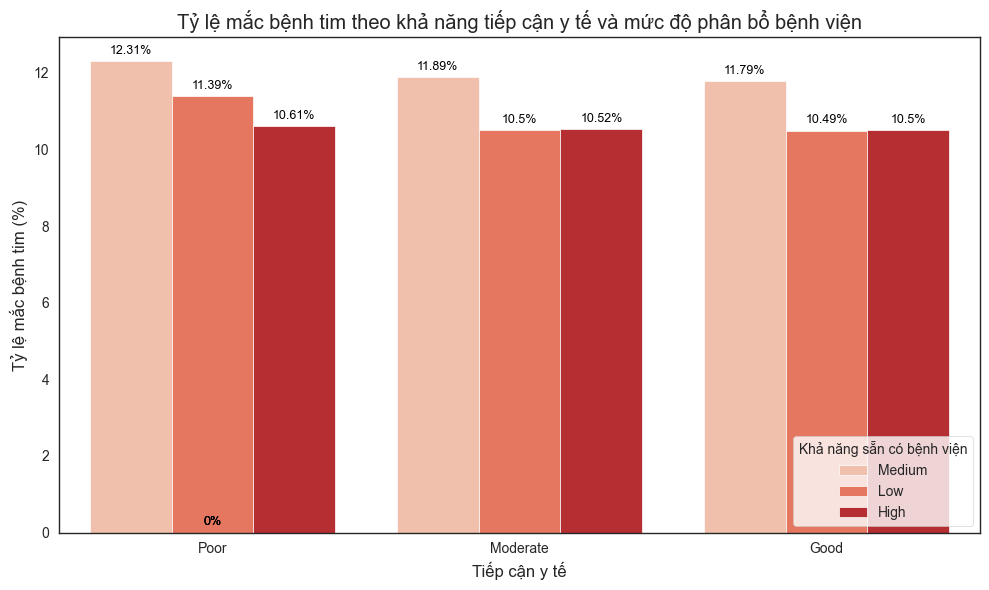

In [51]:
plt.figure(figsize=(10,6))

# Vẽ biểu đồ cột nhóm
ax = sns.barplot(
    data=df_8,
    x="Healthcare_Access",
    y="Heart_Attack_Percentage",
    hue="Hospital_Availability",
    palette="Reds"
)

# Thêm nhãn dữ liệu trên mỗi cột
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

plt.title("Tỷ lệ mắc bệnh tim theo khả năng tiếp cận y tế và mức độ phân bổ bệnh viện")
plt.ylabel("Tỷ lệ mắc bệnh tim (%)")
plt.xlabel("Tiếp cận y tế")
plt.legend(title="Khả năng sẵn có bệnh viện")
plt.tight_layout()
plt.show()

In [52]:
#Câu 9
print("Câu 9: Đặc điểm của người dùng y học cổ truyền theo nhóm kinh tế xã hội")
df_9=spark.sql(f"""
    SELECT
        TCM_Use,
        Education_Level,
        Income_Level,
        Employment_Status,
        COUNT(*) AS Patient_Count,
        ROUND(
            100.0 * COUNT(*) / {total_heart_attack},
            2
        ) AS Heart_Attack_Percentage
    FROM heart_attack
    WHERE Heart_Attack = 'Yes'
    GROUP BY TCM_Use, Education_Level, Income_Level, Employment_Status
    ORDER BY Heart_Attack_Percentage DESC
""").toPandas()
df_9

Câu 9: Đặc điểm của người dùng y học cổ truyền theo nhóm kinh tế xã hội


,TCM_Use,Education_Level,Income_Level,Employment_Status,Patient_Count,Heart_Attack_Percentage
0,No,Higher,High,Retired,2459,1.78
1,No,Secondary,High,Retired,2410,1.75
2,No,None,Middle,Retired,2405,1.74
3,No,Primary,Middle,Retired,2365,1.71
4,No,Primary,Low,Unemployed,2361,1.71
...,...,...,...,...,...,...
67,Yes,Secondary,Middle,Unemployed,1484,1.07
68,Yes,Secondary,High,Retired,1484,1.07
69,Yes,Higher,Middle,Retired,1479,1.07
70,Yes,None,Middle,Unemployed,1455,1.05


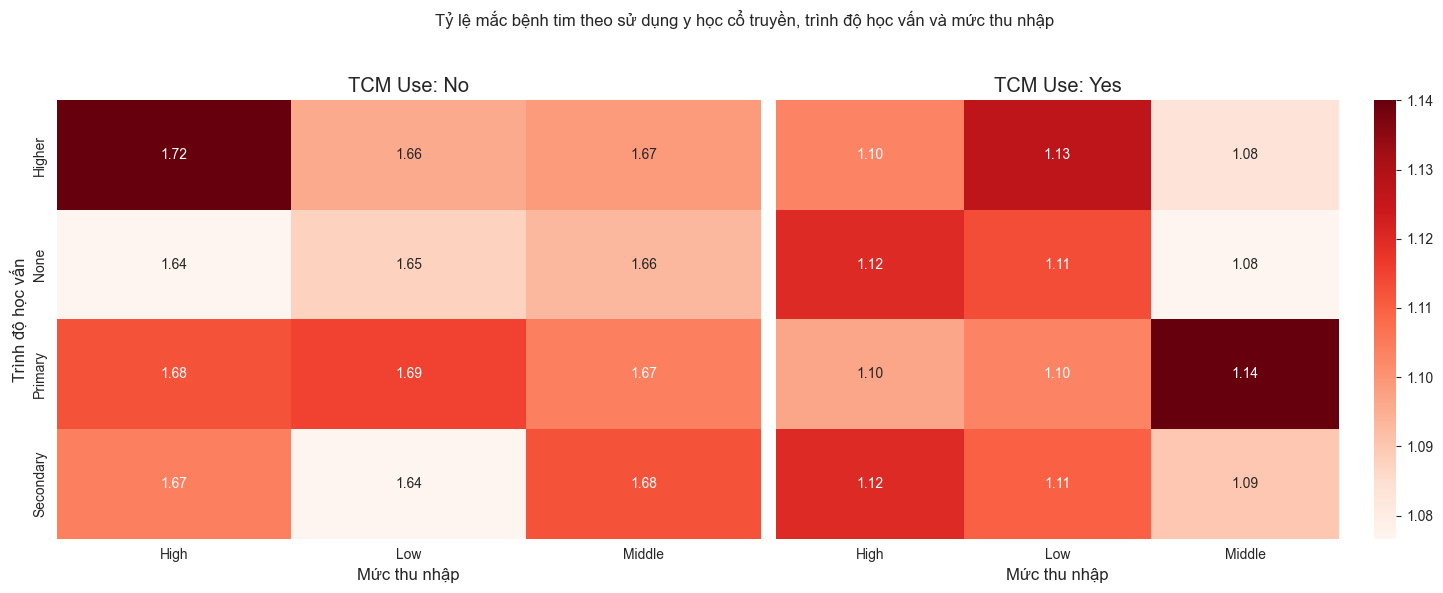

In [54]:
# Chuyển Heart_Attack_Percentage sang float
df_9['Heart_Attack_Percentage'] = df_9['Heart_Attack_Percentage'].astype(float)

# Lấy danh sách các nhóm TCM_Use
tcm_groups = df_9['TCM_Use'].unique()

# Tạo figure với số cột = số nhóm TCM_Use
fig, axes = plt.subplots(1, len(tcm_groups), figsize=(15, 6), sharey=True)

for i, tcm in enumerate(tcm_groups):
    ax = axes[i]
    subset = df_9[df_9['TCM_Use'] == tcm]

    # Dùng pivot_table
    pivot_table = subset.pivot_table(
        index='Education_Level',
        columns='Income_Level',
        values='Heart_Attack_Percentage',
        aggfunc='mean'
    ).fillna(0)

    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds", cbar=(i == len(tcm_groups) - 1), ax=ax)
    ax.set_title(f"TCM Use: {tcm}")
    ax.set_xlabel("Mức thu nhập")
    if i == 0:
        ax.set_ylabel("Trình độ học vấn")
    else:
        ax.set_ylabel("")

plt.suptitle("Tỷ lệ mắc bệnh tim theo sử dụng y học cổ truyền, trình độ học vấn và mức thu nhập")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [27]:
#Câu 10: Nguy cơ tái phát ở người có tiền sử bệnh tim nếu họ sử dụng bia, rượu và có thói quen xấu
# Tính tổng số người có Heart_Attack = 'Yes'
print("Câu 10: Nguy cơ tái phát ở người có tiền sử bệnh tim theo nhóm  hành vi sức khỏe và lối sống")
# Truy vấn số ca theo từng nhóm (tử số)
df_10 = spark.sql(f"""
    SELECT *
    FROM (
        SELECT 'Smoking_Status' AS Factor,
               Smoking_Status AS Value,
               COUNT(*) AS Heart_Attack_Cases,
               ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY 'Smoking_Status'), 2) AS Heart_Attack_Percentage
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' and Previous_Heart_Attack = 'Yes'
        GROUP BY Smoking_Status

        UNION ALL

        SELECT 'Alcohol_Consumption' AS Factor,
               Alcohol_Consumption AS Value,
               COUNT(*) AS Heart_Attack_Cases,
               ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY 'Alcohol_Consumption'), 2) AS Heart_Attack_Percentage
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' and Previous_Heart_Attack = 'Yes'
        GROUP BY Alcohol_Consumption

        UNION ALL

        SELECT 'Physical_Activity' AS Factor,
               Physical_Activity AS Value,
               COUNT(*) AS Heart_Attack_Cases,
               ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY 'Physical_Activity'), 2) AS Heart_Attack_Percentage
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' and Previous_Heart_Attack = 'Yes'
        GROUP BY Physical_Activity

        UNION ALL

        SELECT 'Diet_Score' AS Factor,
               Diet_Score AS Value,
               COUNT(*) AS Heart_Attack_Cases,
               ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY 'Diet_Score'), 2) AS Heart_Attack_Percentage
        FROM heart_attack
        WHERE Heart_Attack = 'Yes' and Previous_Heart_Attack = 'Yes'
        GROUP BY Diet_Score
    ) AS union_data
    ORDER BY Factor ASC, Heart_Attack_Percentage DESC
""").toPandas()
df_10

Câu 10: Nguy cơ tái phát ở người có tiền sử bệnh tim theo nhóm  hành vi sức khỏe và lối sống


,Factor,Value,Heart_Attack_Cases,Heart_Attack_Percentage
0,Alcohol_Consumption,Yes,11978,84.45
1,Alcohol_Consumption,No,2205,15.55
2,Diet_Score,Poor,4752,33.50
3,Diet_Score,Healthy,4742,33.43
4,Diet_Score,Moderate,4689,33.06
5,Physical_Activity,Low,4749,33.48
6,Physical_Activity,Medium,4719,33.27
7,Physical_Activity,High,4715,33.24
8,Smoking_Status,Smoker,8083,56.99
9,Smoking_Status,Non-Smoker,6100,43.01


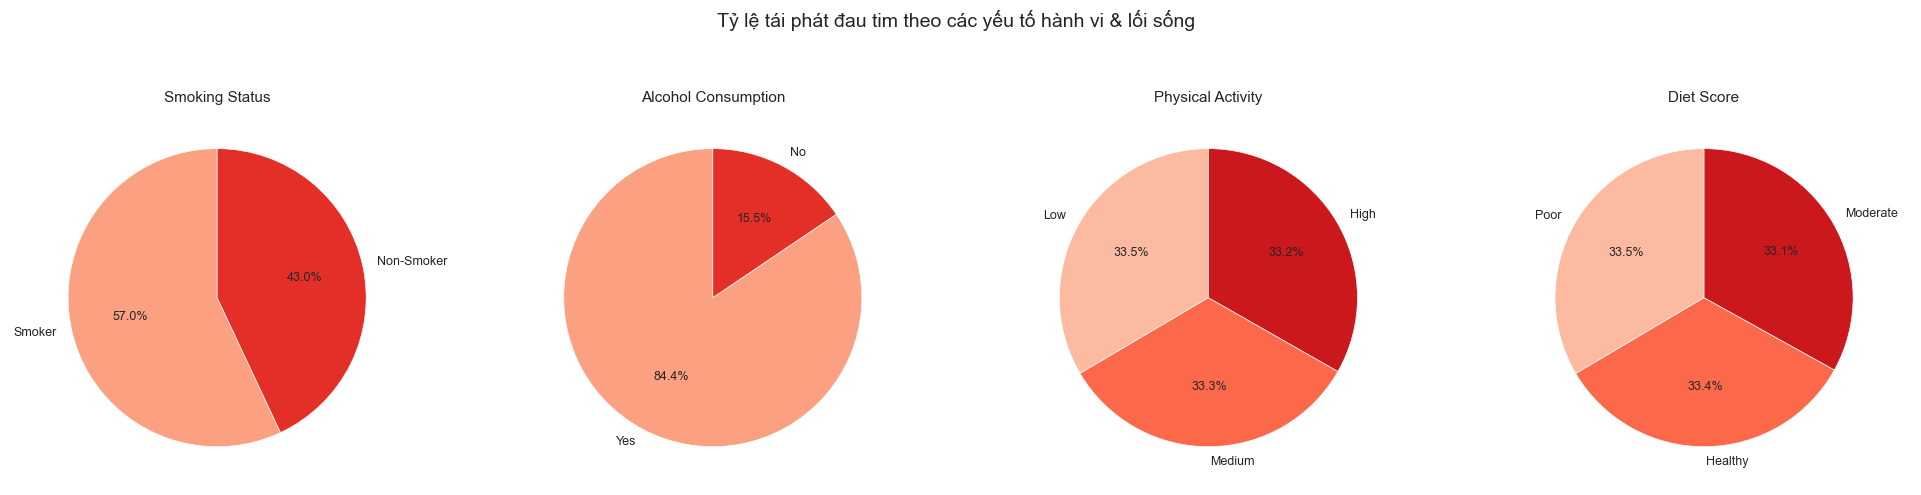

In [28]:
# Tạo danh sách các yếu tố cần vẽ
factors = ["Smoking_Status", "Alcohol_Consumption", "Physical_Activity", "Diet_Score"]

# Tạo khung vẽ gồm 1 hàng, 4 cột
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Lặp qua từng yếu tố và vẽ biểu đồ pie tương ứng
for i, factor in enumerate(factors):
    # Lọc dữ liệu theo từng yếu tố
    df_factor = df_10[df_10["Factor"] == factor]

    # Dữ liệu cho pie chart
    labels = df_factor["Value"]
    sizes = df_factor["Heart_Attack_Percentage"]

    # Tạo bảng màu đỏ nhạt đến đậm
    colors = sns.color_palette("Reds", len(sizes))

    # Vẽ pie chart
    wedges, texts, autotexts = axes[i].pie(
        sizes,
        labels=labels,
        autopct="%.1f%%",
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )

    axes[i].axis("equal")
    axes[i].set_title(factor.replace("_", " "), fontsize=11)

# Tiêu đề chung
plt.suptitle("Tỷ lệ tái phát đau tim theo các yếu tố hành vi & lối sống", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()